In [1]:
%reset -f

In [2]:
import numpy as np
import torchdiffeq
import torch
import torch.nn as nn
import torch.optim as optim
from typing import List

In [3]:
torch.cuda.empty_cache()

In [4]:
# --- build a simple rod: 3 DOF per node (x,y,z) ---
def create_rod_with_nodes(num_nodes: int):
    nodes = []
    for i in range(num_nodes):
        nodes.append(np.array([i * 0.1, 0.0, 0.0], dtype=np.float32))
    return nodes
num_nodes = 11
nodes = create_rod_with_nodes(num_nodes)  # 11 nodes -> ndof = 33
q0 = np.array(nodes, dtype=np.float32).reshape(-1)         # positions (ndof,)
v0 = np.zeros_like(q0, dtype=np.float32)                   # velocities (ndof,)
x0 = torch.tensor(np.concatenate([q0, v0]), dtype=torch.float32)  # (2*ndof,)

print("Initial state x0:", x0)

# create springs (3 consecutive nodes and effective length)
stretch_springs = []
bend_springs = []
for i in range(0, num_nodes):
    if i == 0:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        stretch_springs.append((i, i + 1, None, l0, None))
    elif i == num_nodes - 1:
        # boundary nodes: leff = 0.05
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        stretch_springs.append((i - 1, i, None, l0, None))
    else:
        # internal nodes: leff = 0.1
        l0 = np.linalg.norm(np.array(nodes[i] - nodes[i-1]))
        l1 = np.linalg.norm(np.array(nodes[i+1] - nodes[i]))
        leff = 0.5 * (l0 + l1)
        stretch_springs.append((i - 1, i, i + 1, l0, l1))
        bend_springs.append((i - 1, i, i + 1, leff))

EA = 1e4  # axial stiffness
EI = 1e2  # bending stiffness

print("Stretch springs:", stretch_springs)
print("Bend springs:", bend_springs)


Initial state x0: tensor([0.0000, 0.0000, 0.0000, 0.1000, 0.0000, 0.0000, 0.2000, 0.0000, 0.0000,
        0.3000, 0.0000, 0.0000, 0.4000, 0.0000, 0.0000, 0.5000, 0.0000, 0.0000,
        0.6000, 0.0000, 0.0000, 0.7000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000,
        0.9000, 0.0000, 0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
Stretch springs: [(0, 1, None, np.float32(0.1), None), (0, 1, 2, np.float32(0.1), np.float32(0.1)), (1, 2, 3, np.float32(0.1), np.float32(0.10000001)), (2, 3, 4, np.float32(0.10000001), np.float32(0.099999994)), (3, 4, 5, np.float32(0.099999994), np.float32(0.099999994)), (4, 5, 6, np.float32(0.099999994), np.float32(0.100000024)), (5, 6, 7, np.float32(0.100000024), np.float32(0.0999999

In [5]:
from stretch_energy import get_stretch_force
from bend_energy import get_bend_force

In [ ]:
from torchdiffeq import odeint


class BeamODE(nn.Module):
    def __init__(self, ndof: int, m_per_dof: float = 1.0, c_per_dof: float = 0.1, g: float = 9.81):
        super().__init__()
        self.ndof = ndof
        # Diagonal mass and damping for now (easy to replace with full matrices later)
        M = torch.eye(ndof) * m_per_dof       # (ndof, ndof)
        C = torch.eye(ndof) * c_per_dof       # (ndof, ndof)
        K = torch.zeros(ndof, ndof)           # placeholder (no elasticity yet)

        # Gravity as external force: acts in z only (every 3rd DOF starting from index 2)
        f_ext = torch.zeros(ndof)
        f_ext[2::3] = -m_per_dof * g          # (ndof,)

        # Register as buffers so dtype/device track the module (and no grads)
        self.register_buffer("M", M)
        self.register_buffer("C", C)
        self.register_buffer("K", K)
        self.register_buffer("f_ext", f_ext)

        # Since M is diagonal/scalar multiple of I, we can precompute its inverse safely
        self.register_buffer("Minv", torch.linalg.inv(M))

    # def elastic_force(self, q: torch.Tensor) -> torch.Tensor:
    #     # Placeholder: F_elastic(q) = K q (with K=0 for now)
    #     # q shape: (..., ndof)
    #     return torch.matmul(q, self.K.T)  # (..., ndof)
    
    def elastic_force(self, q: torch.Tensor) -> torch.Tensor:

        # Compute elastic forces from stretch and bend springs
        q_np = q.detach().cpu().numpy()  # (3*num_nodes, 1)
        print("q_np inside elastic_force:", q_np)  # Debug print
        # Stretch forces
        f_stretch = get_stretch_force(q_np, stretch_springs, EA)  # (num_nodes, 3)
        # Bend forces
        f_bend = get_bend_force(q_np, bend_springs, EI)

        f_elastic = torch.tensor(f_stretch, dtype=q.dtype, device=q.device) + torch.tensor(f_bend, dtype=q.dtype, device=q.device)  # (num_nodes, 3)
        # f_elastic = torch.tensor(f_stretch, dtype=q.dtype, device=q.device)

        return f_elastic

    def forward(self, t: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        """
        x shape: (..., 2*ndof)
        Returns dx/dt with same shape.
        """
        ndof = self.ndof
        q = x[..., :ndof]        # (..., ndof)
        v = x[..., ndof:]        # (..., ndof)

        # Forces
        f_el = self.elastic_force(q)          # (..., ndof)
        f_damp = torch.matmul(v, self.C.T)    # (..., ndof)
        # Note: torch.matmul handles batch as long as the left arg has the batch dim

        # Acceleration: a = Minv @ ( -C v - F_el + f_ext )
        rhs = -f_damp - f_el + self.f_ext     # (..., ndof)
        # If M is diagonal/constant, broadcasting Minv works with rhs
        a = torch.matmul(rhs, self.Minv.T)    # (..., ndof)

        dxdt = torch.cat([v, a], dim=-1)      # (..., 2*ndof)
        return dxdt

# --- set up and integrate ---
ndof = q0.size
f = BeamODE(ndof=ndof, m_per_dof=1.0, c_per_dof=0.1, g=9.81)

t = torch.linspace(0.0, 1.0, 101)            # 101 time samples over 1 second
sol = odeint(f, x0, t, method='dopri5')      # shape: (T, 2*ndof)

print("Solution shape:", sol.shape)           # (T, 2*ndof)
q_traj = sol[:, :ndof]                        # (T, ndof)
v_traj = sol[:, ndof:]                        # (T, ndof)
print("q_traj[0]:", q_traj[0, :6])
print("v_traj[0]:", v_traj[0, :6])


q_np inside elastic_force: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0. ]
q_np inside elastic_force: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0. ]
q_np inside elastic_force: [0.  0.  0.  0.1 0.  0.  0.2 0.  0.  0.3 0.  0.  0.4 0.  0.  0.5 0.  0.
 0.6 0.  0.  0.7 0.  0.  0.8 0.  0.  0.9 0.  0.  1.  0.  0. ]
q_np inside elastic_force: [ 0.0000000e+00  0.0000000e+00 -3.9434508e-07  1.0000000e-01
  0.0000000e+00 -3.9434508e-07  2.0000000e-01  0.0000000e+00
 -3.9434508e-07  3.0000001e-01  0.0000000e+00 -3.9434508e-07
  4.0000001e-01  0.0000000e+00 -3.9434508e-07  5.0000000e-01
  0.0000000e+00 -3.9434508e-07  6.0000002e-01  0.0000000e+00
 -3.9434508e-07  6.9999999e-01  0.0000000e+00 -3.9434508e-07
  8.0000001e-01  0.0000000e+00 -3.9434508e-07  8.9999998e-01
  0.0000000e+00 -3.9434508e-07  1.0000000e+00  0.0000000e+00
 -

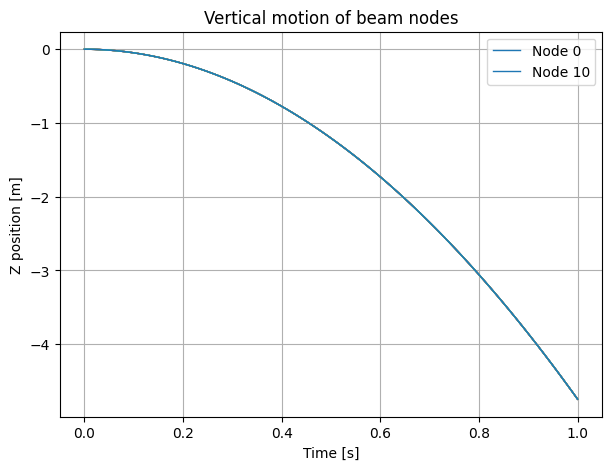

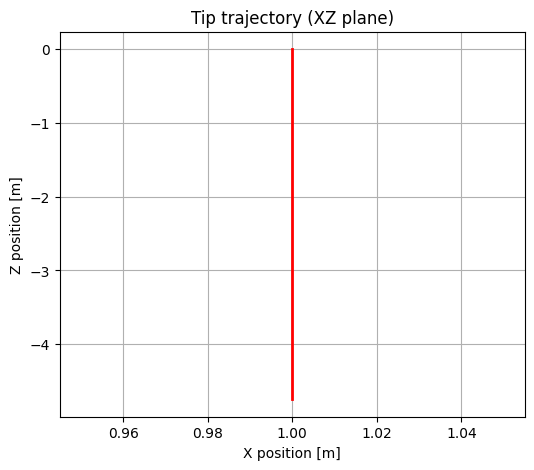

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert trajectory to numpy
q_traj_np = q_traj.detach().numpy().reshape(len(t), num_nodes, 3)

# Plot Z-displacement (vertical motion) of each node
plt.figure(figsize=(7, 5))
for i in range(num_nodes):
    plt.plot(t, q_traj_np[:, i, 2], label=f'Node {i}' if i in [0, num_nodes-1] else "", lw=1)
plt.xlabel("Time [s]")
plt.ylabel("Z position [m]")
plt.title("Vertical motion of beam nodes")
plt.legend()
plt.grid(True)
plt.show()

# Plot trajectory of beam tip (last node)
plt.figure(figsize=(6, 5))
plt.plot(q_traj_np[:, -1, 0], q_traj_np[:, -1, 2], 'r-', lw=2)
plt.xlabel("X position [m]")
plt.ylabel("Z position [m]")
plt.title("Tip trajectory (XZ plane)")
plt.grid(True)
plt.show()


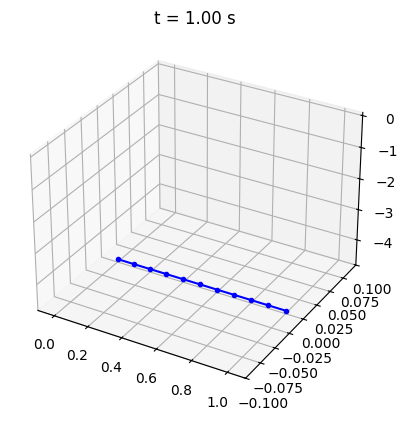

In [8]:
import matplotlib.animation as animation

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def update(frame):
    ax.cla()
    ax.plot(q_traj_np[frame, :, 0],
            q_traj_np[frame, :, 1],
            q_traj_np[frame, :, 2],
            'b.-')
    ax.set_xlim([q_traj_np[:, :, 0].min()-0.1, q_traj_np[:, :, 0].max()+0.1])
    ax.set_ylim([q_traj_np[:, :, 1].min()-0.1, q_traj_np[:, :, 1].max()+0.1])
    ax.set_zlim([q_traj_np[:, :, 2].min()-0.1, q_traj_np[:, :, 2].max()+0.1])
    ax.set_title(f"t = {t[frame]:.2f} s")
    return ax

ani = animation.FuncAnimation(fig, update, frames=range(0, len(t), 5), interval=50)
ani.save("beam_motion.gif", writer="ffmpeg", fps=20)
plt.show()
